In [16]:
# Cell 1: Imports

import os
import numpy as np
import pandas as pd

from skimage.transform import resize
from skimage.io import imread

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

sns.set()
RANDOM_STATE = 42


In [17]:
target = []
images = []   # In matrix format
flat_data = []  # In vector format

datadir = '../Data/AppleData'
categories = ['Apple___Apple_scab',
              'Apple___Black_rot',
              'Apple___Cedar_apple_rust',
              'Apple___healthy',
              'Background_without_leaves']

for category in categories:
  path= datadir + '/' + category
  for img in os.listdir(path):
    img_matrix=imread(os.path.join(path,img))
    img_resized=resize(img_matrix,(150,150,3))
    flat_data.append(img_resized.flatten())
    images.append(img_resized)
    target.append(category)

In [18]:
import pandas as pd
df=pd.DataFrame(flat_data)
df['Target']=target

In [19]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [33]:
# Cell 4: Imports for Neural Network model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Ensure reproducibility (use same RANDOM_STATE if you already defined one)
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


In [34]:
# Cell 5: Prepare features (X) and labels (y) for the NN
# Assumes your dataframe is called `df` and the target column is named "Target"

# 1. Separate features and target
X = df.drop(columns=["Target"]).astype("float32").values
y = df["Target"].values

X = df.drop(columns=["Target"]).astype("float32").values
y = df["Target"].values
...

print("Feature matrix shape:", X.shape)
print("First 5 labels:", y[:5])

# 2. Encode labels to integers, then one-hot for Keras
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

print("Classes:", label_encoder.classes_)
print("Encoded labels shape (one-hot):", y_onehot.shape)


Feature matrix shape: (5788, 67500)
First 5 labels: ['Apple___Apple_scab' 'Apple___Apple_scab' 'Apple___Apple_scab'
 'Apple___Apple_scab' 'Apple___Apple_scab']
Classes: ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Background_without_leaves']
Encoded labels shape (one-hot): (5788, 5)


In [35]:
# Cell 5a: Apply PCA to reduce dimensionality

# Standardize first (PCA expects scaled data)
scaler_pca = StandardScaler()
X_scaled_for_pca = scaler_pca.fit_transform(X)

# Keep 95% of variance (you can adjust this)
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled_for_pca)

print("Original feature dimension:", X.shape[1])
print("PCA-transformed feature dimension:", X_pca.shape[1])


Original feature dimension: 67500
PCA-transformed feature dimension: 1009


In [36]:
# Cell 6: Train/validation/test split and scaling using RAW features (no PCA)

# Use raw X instead of X_pca
# Also use y_encoded (1D) for stratify to be safe
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y_onehot,
    test_size=0.2,
    stratify=y_encoded,        # <--- stratify on 1D labels
    random_state=RANDOM_STATE
)

# Train vs validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,
    stratify=np.argmax(y_temp, axis=1),  # again use 1D labels for stratify
    random_state=RANDOM_STATE
)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

# Scale raw features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
print("Input dimension for NN:", input_dim)


X_train: (3704, 67500)
X_val: (926, 67500)
X_test: (1158, 67500)
Input dimension for NN: 67500


In [37]:
# Cell 7: Build the improved neural network model (with BatchNorm and extra layer)

def build_nn_model(input_dim, num_classes):
    model = Sequential()
    
    # Layer 1
    model.add(Dense(256, activation="relu", input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Layer 2
    model.add(Dense(128, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Layer 3
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(num_classes, activation="softmax"))
    
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_nn_model(input_dim=input_dim, num_classes=num_classes)
model.summary()


/home/ahw8xz/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │    17,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,323,525 (66.08 MB)

 Trainable params: 17,322,629 (66.08 MB)

 Non-trainable params: 896 (3.50 KB)

In [42]:
# Cell 7b: Alternative, slightly smaller NN to compare

def build_nn_model_v2(input_dim, num_classes):
    model = Sequential()
    
    # Layer 1
    model.add(Dense(128, activation="relu", input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))   # slightly less dropout
    
    # Layer 2
    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    # Output
    model.add(Dense(num_classes, activation="softmax"))
    
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model_v2 = build_nn_model_v2(input_dim=input_dim, num_classes=num_classes)
model_v2.summary()


/home/ahw8xz/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,649,477 (33.00 MB)

 Trainable params: 8,649,093 (32.99 MB)

 Non-trainable params: 384 (1.50 KB)

In [38]:
# Cell 8: Train the model with early stopping + learning rate schedule

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,              # allow a bit more patience
    restore_best_weights=True,
    verbose=1
)

lr_decay = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,              # halve the LR when stuck
    patience=3,              # if no improvement for 3 epochs
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,               # max epochs; early stopping will cut this short
    batch_size=32,
    callbacks=[early_stop, lr_decay],
    verbose=1
)


Epoch 1/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6220 - loss: 1.0352 - val_accuracy: 0.7711 - val_loss: 0.6301 - learning_rate: 0.0010
Epoch 2/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7824 - loss: 0.5894 - val_accuracy: 0.8575 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 3/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8626 - loss: 0.3879 - val_accuracy: 0.8931 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 4/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8934 - loss: 0.3118 - val_accuracy: 0.8996 - val_loss: 0.2747 - learning_rate: 0.0010
Epoch 5/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9158 - loss: 0.2398 - val_accuracy: 0.8952 - val_loss: 0.2965 - learning_rate: 0.0010
Epoch 6/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9387 - loss: 0.1800 - val_accuracy: 0.8952 - val_loss: 0.3063 - learning_rate: 0.0010
Epoch 7/80
115/116 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9502 - loss: 0.

In [43]:
# Cell 8b: Train model_v2 with early stopping + LR schedule and smaller batch size

early_stop_v2 = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True,
    verbose=1
)

lr_decay_v2 = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

history_v2 = model_v2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,
    batch_size=16,        # <--- smaller batch size
    callbacks=[early_stop_v2, lr_decay_v2],
    verbose=1
)


Epoch 1/80
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6655 - loss: 0.9068 - val_accuracy: 0.8596 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 2/80
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8215 - loss: 0.4955 - val_accuracy: 0.8823 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 3/80
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8853 - loss: 0.3305 - val_accuracy: 0.8942 - val_loss: 0.3072 - learning_rate: 0.0010
Epoch 4/80
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9195 - loss: 0.2309 - val_accuracy: 0.8909 - val_loss: 0.3048 - learning_rate: 0.0010
Epoch 5/80
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9336 - loss: 0.1873 - val_accuracy: 0.9093 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 6/80
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9560 - loss: 0.1407 - val_accuracy: 0.8963 - val_loss: 0.3262 - learning_rate: 0.0010
Epoch 7/80
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9598 - loss: 0.

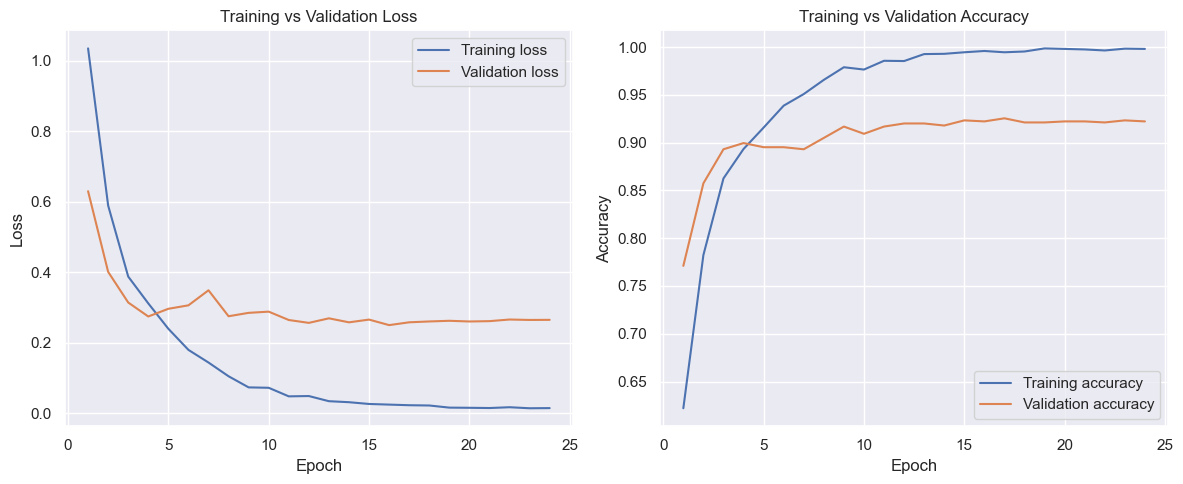

In [39]:
# Cell 9: Plot training and validation loss/accuracy

history_dict = history.history

epochs = range(1, len(history_dict["loss"]) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict["loss"], label="Training loss")
plt.plot(epochs, history_dict["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict["accuracy"], label="Training accuracy")
plt.plot(epochs, history_dict["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
# Cell 10: Evaluate model on test data

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predicted class indices
y_test_pred_probs = model.predict(X_test_scaled)
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1)

# True class indices
y_test_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(
    y_test_true_labels,
    y_test_pred_labels,
    target_names=label_encoder.classes_
))


Test Loss: 0.2518
Test Accuracy: 0.9240
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Classification Report:

                           precision    recall  f1-score   support

       Apple___Apple_scab       0.90      0.81      0.85       200
        Apple___Black_rot       0.94      0.88      0.91       200
 Apple___Cedar_apple_rust       0.89      0.99      0.94       200
          Apple___healthy       0.91      0.96      0.93       329
Background_without_leaves       0.98      0.97      0.97       229

                 accuracy                           0.92      1158
                macro avg       0.93      0.92      0.92      1158
             weighted avg       0.92      0.92      0.92      1158



In [44]:
# Cell 10b: Evaluate model_v2 on test set

test_loss_v2, test_acc_v2 = model_v2.evaluate(X_test_scaled, y_test, verbose=0)
print(f"[Model v2] Test Loss: {test_loss_v2:.4f}")
print(f"[Model v2] Test Accuracy: {test_acc_v2:.4f}")

y_test_pred_probs_v2 = model_v2.predict(X_test_scaled)
y_test_pred_labels_v2 = np.argmax(y_test_pred_probs_v2, axis=1)
y_test_true_labels = np.argmax(y_test, axis=1)  # same as before

print("\n[Model v2] Classification Report:\n")
print(classification_report(
    y_test_true_labels,
    y_test_pred_labels_v2,
    target_names=label_encoder.classes_
))


[Model v2] Test Loss: 0.3193
[Model v2] Test Accuracy: 0.8886
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

[Model v2] Classification Report:

                           precision    recall  f1-score   support

       Apple___Apple_scab       0.85      0.75      0.80       200
        Apple___Black_rot       0.87      0.85      0.86       200
 Apple___Cedar_apple_rust       0.87      0.97      0.92       200
          Apple___healthy       0.88      0.91      0.90       329
Background_without_leaves       0.96      0.94      0.95       229

                 accuracy                           0.89      1158
                macro avg       0.89      0.88      0.88      1158
             weighted avg       0.89      0.89      0.89      1158



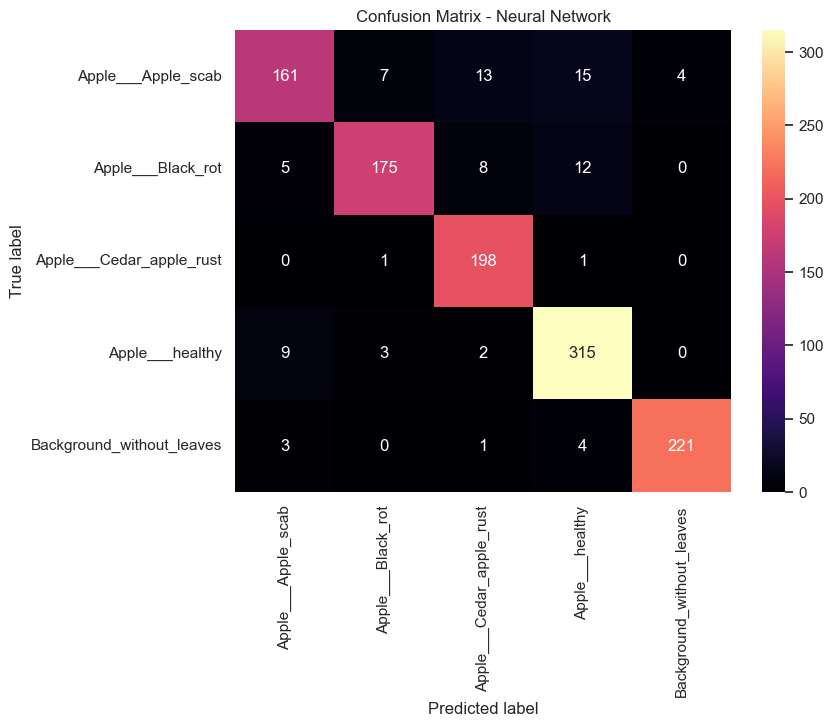

In [41]:
# Cell 11: Confusion matrix for NN model

cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="magma",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Neural Network")
plt.show()
